## Notes on features to choose:

### From Kaggle Kernels:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis/comments#latest-185178

* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* Look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank/comments/notebook

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook

* replace regions with map shapefile coordinates



**Price by Region**
<img src="price_by_region.png" width="550"/> 
**Price by Region (city center)**
<img src="center_transacation_prices.png" width="550"/>


**Average Price per Region**
<img src="avg_price_per_region.png", width="550">
**Average Price Squared per Region**
<img src="avg_price_squared_per_region.png", width="550">
**Okrugs**
<img src="okrug.png", width="550">
**# of Sales per Region**
<img src="sales_per_region.png", width="550">




### Functions for Scaling/Normalizing/Reshaping

In [24]:
# rescale data using the mean and sd 
def rescale(feature):
    return feature.apply(lambda x: (x - np.mean(x))/np.std(x))

# # normalize data
# from sklearn.preprocessing import Normalizer

def normalize(feature):
    return feature.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

### Functions for Rolling Statistics on Time-Series

In [25]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

### Pipeline To Do:
* Look into kriging regression model for geospatial features
* Plot price to gender/age/subregion.
* subregions
    * linear reg to predict price just with subregion and size
    * mean/sd/var/median. 
    * see how well you can predict the sub-region by using price and size of home as features. 
    * max floors vs. price per subregion
* Look into Agglomerate features (merging two similar features)

## Import Libraries & Data

In [401]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

In [96]:
# load dataset
train_df = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'], index_col=False)
test_df = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)

### Add Month, Day, and Year Columns and Merge Train and Test 

In [97]:
# add month, day, year to train and test data
train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['year'] = train_df['timestamp'].dt.year

In [98]:
# merge training and test data set
frames = [train_df, test_df]

df = pd.concat(frames)

### Transformations on Train/Test Data:

#### log+1 and natural log for Price:

In [99]:
df['price_doc_log'] = np.log1p(df['price_doc'])
df['price_doc_log10'] = np.log10(df['price_doc'])

#### Square root and squared for apartment/home size:

In [100]:
df['full_sq^2'] = np.square(df['full_sq'])
df['full_sqrt'] = np.sqrt(df['full_sq'])

### Add Median Train/Test values to Macro

In [101]:
gb_median = df.groupby(['timestamp'], as_index=False).median()

macro_df = pd.merge(macro_df, gb_median.loc[:, ], how='left', on='timestamp')

macro_df.shape

(2484, 383)

In [102]:
macro_df.sample(4)

timestamp  oil_urals  gdp_quart  gdp_quart_growth    cpi    ppi  \
2263 2016-03-13    36.6171    22016.1              -3.8  518.5  551.9   
2314 2016-05-03    45.0185    18561.3              -1.2  523.2  584.0   
1443 2013-12-14   110.6220    18543.5               1.3  403.9  480.6   
2412 2016-08-09    43.8159    19979.4              -0.6  530.1  606.1   

      gdp_deflator  balance_trade  balance_trade_growth   usdrub    ...      \
2263       133.160          7.991                   9.4  69.7079    ...       
2314       133.160          7.439                   8.0  66.6133    ...       
1443       108.299         20.191                  10.5  32.8727    ...       
2412       133.160          7.507                  -0.9  64.7552    ...       

      workplaces_km    year  young_all  young_female  young_male  \
2263            NaN     NaN        NaN           NaN         NaN   
2314       1.876282     NaN    19487.0       10196.0      9291.0   
1443       1.679747  2013.0    13876.5        6807.0      7069.5   
2412            NaN     NaN        NaN           NaN         NaN   

      zd_vokzaly_avto_km  price_doc_log  price_doc_log10  full_sq^2  full_sqrt  
2263                 NaN            NaN              NaN        NaN        NaN  
2314           12.518123            NaN              NaN  1649.9844   6.373382  
1443           14.153009      15.687313         6.812913  1521.0000   6.244998  
2412                 NaN            NaN              NaN        NaN        NaN  

[4 rows x 383 columns]

## Cleaning Missing and Incorrect Values

In [103]:
# Cleaning values with incorrect information 
macro_df.loc[macro_df['state'] == 33, 'status'] = 3
macro_df = macro_df.loc[macro_df['id'] != 24718] 
macro_df = macro_df.loc[macro_df['floor'] != 0] 

#### Cleaning the build year

In [104]:
macro_df.loc[macro_df['build_year'] == 20052009, 'build_year'] = 2009
macro_df.loc[macro_df['build_year'] == 215, 'build_year'] = 2015
macro_df = macro_df.loc[macro_df['build_year'] != 4965, :]
df.loc[df['build_year'] == 0, 'build_year'] = 2015
df.loc[df['build_year'] == 1, 'build_year'] = 2016
df.loc[df['build_year'] == 2, 'build_year'] = 2017

#### Number of null features in macro.csv per column

In [105]:
macro_df.apply(lambda x: x.isnull()).sum().sort_values(ascending=False).tail(30)

rent_price_3room_bus                   273
rent_price_4+room_bus                  273
rent_price_1room_bus                   273
rent_price_3room_eco                   273
rent_price_2room_eco                   273
rent_price_1room_eco                   273
rent_price_2room_bus                   273
gdp_quart_growth                        90
gdp_quart                               90
balance_trade_growth                    90
cpi                                     31
deposits_growth                         31
ppi                                     31
balance_trade                           31
micex_rgbi_tr                           10
rts                                     10
micex                                   10
brent                                    3
eurrub                                   3
usdrub                                   3
micex_cbi_tr                             1
gdp_annual_growth                        0
gdp_annual                               0
average_pro

In [109]:
gdp_feats = ['gdp_quart_growth', 'gdp_quart', 'balance_trade_growth',
            'cpi', 'deposits_growth', 'ppi', 
            'balance_trade', 'micex_rgbi_tr', 'rts', 'micex', 'brent', 
            'eurrub', 'usdrub', 'micex_cbi_tr', 'gdp_annual_growth',
            'gdp_annual', 'average_provision_of_build_contract',
            'deposits_value', 'mortgage_value', 'mortgage_rate',
            'fixed_basket','oil_urals', 'timestamp', 'price_doc', 
             'price_doc_log', 'full_sq', 'full_sq^2', 'full_sqrt']

gdp_df = macro_df[gdp_feats].dropna().set_index('timestamp')

In [192]:
important_features = ['id', 'full_sq', 'life_sq', 'floor',
                      'max_floor', 'material', 'build_year',
                      'num_room', 'kitch_sq', 'state', 'area_m',
                      'price_doc', 'gdp_quart', 'deposits_value', 
                      'deposits_growth', 'deposits_rate', 'mortgage_value',
                      'mortgage_growth', 'mortgage_rate', 'salary',
                      'unemployment', 'employment',  'oil_urals',
                      'stadium_km', 'floor', 'max_floor', 'metro_min_avto',
                      'build_year', 'cafe_count_5000_price_high', 'num_room',
                      'radiation_km',
                      'green_zone_km', 'industrial_km', 'indust_part',
                      'cpi', 'cafe_count_5000', 'cafe_count_1500_price_high',
                      'cafe_count_5000_price_500', 'cafe_count_2000_price_2500',
                      'kitch_sq', 'max_floor', 'trc_sqm_5000', 
                      'office_sqm_1000', 'trc_sqm_1500', 'office_sqm_500', 'cpi', 
                      'office_sqm_5000', 'ID_railroad_terminal', 'office_sqm_1500', 
                      'ekder_male', 'raion_popul', 'price_doc']

### Scale data around [0-1]

In [141]:
gdp_df = pd.DataFrame(sklearn.preprocessing.minmax_scale(gdp_df), 
                      index=gdp_df.index, columns=gdp_df.columns)

### Normalize Data

In [224]:
norm_gdp = pd.DataFrame(sklearn.preprocessing.normalize(gdp_df), 
                      index=gdp_df.index, columns=gdp_df.columns)

### Replace sub_areas with Factors

In [145]:
enc = preprocessing.OneHotEncoder()

enc.fit()  
OneHotEncoder(categorical_features='all', dtype=<... 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)
>>> enc.transform([[0, 1, 3]]).toarray()
array([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]])

### Macro start and end date

In [113]:
print "macro.csv start date: {0}".format(macro_df['timestamp'].min())
print "macro.csv end date: {0}".format(macro_df['timestamp'].max())

macro.csv start date: 2010-01-01 00:00:00
macro.csv end date: 2016-10-19 00:00:00


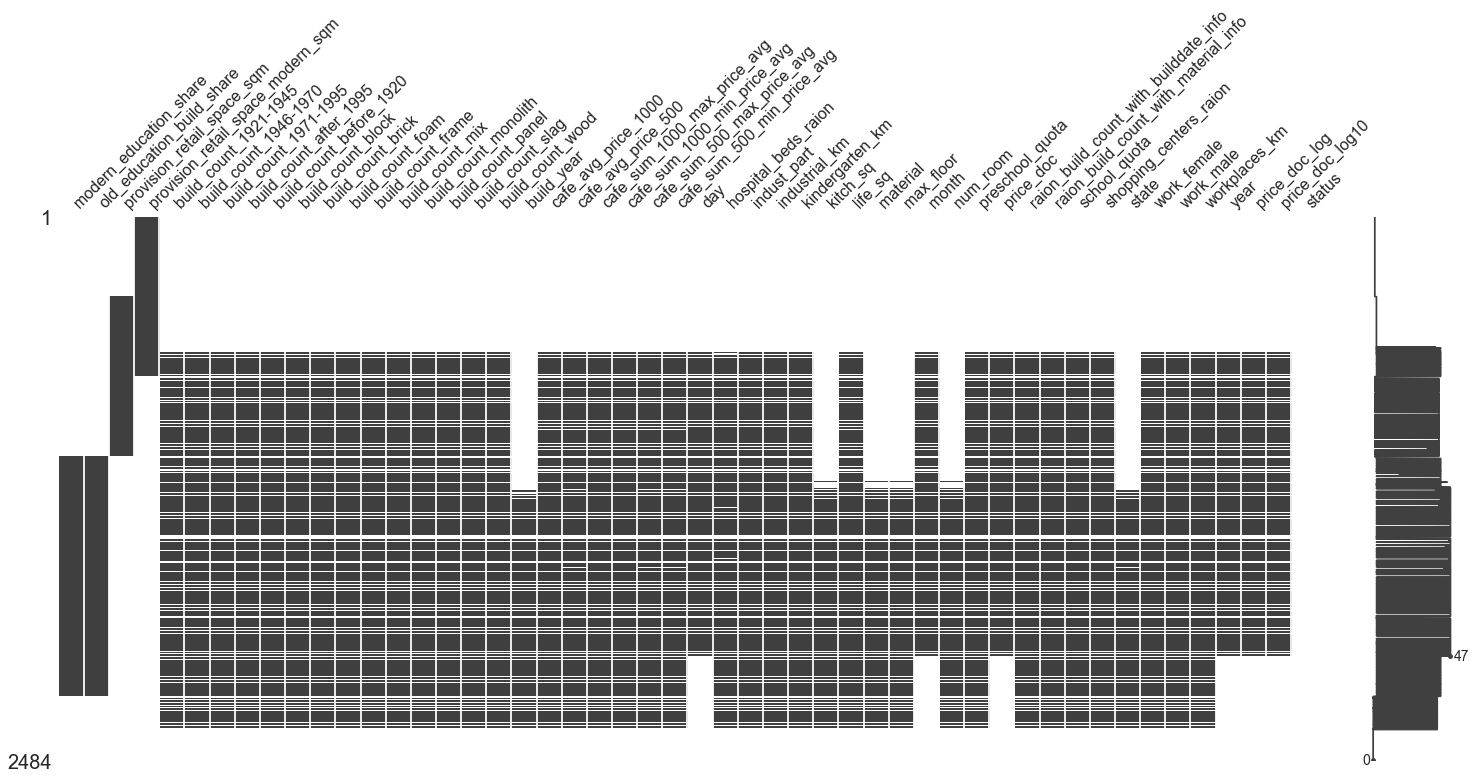

In [114]:
import missingno as msno

macro_df.set_index('timestamp')
filtered_data = msno.nullity_filter(macro_df, filter='bottom', n=50, p=0.99) # or filter='top'

msno.missingno.matrix(filtered_data)

#### Distribution of different GDP Features

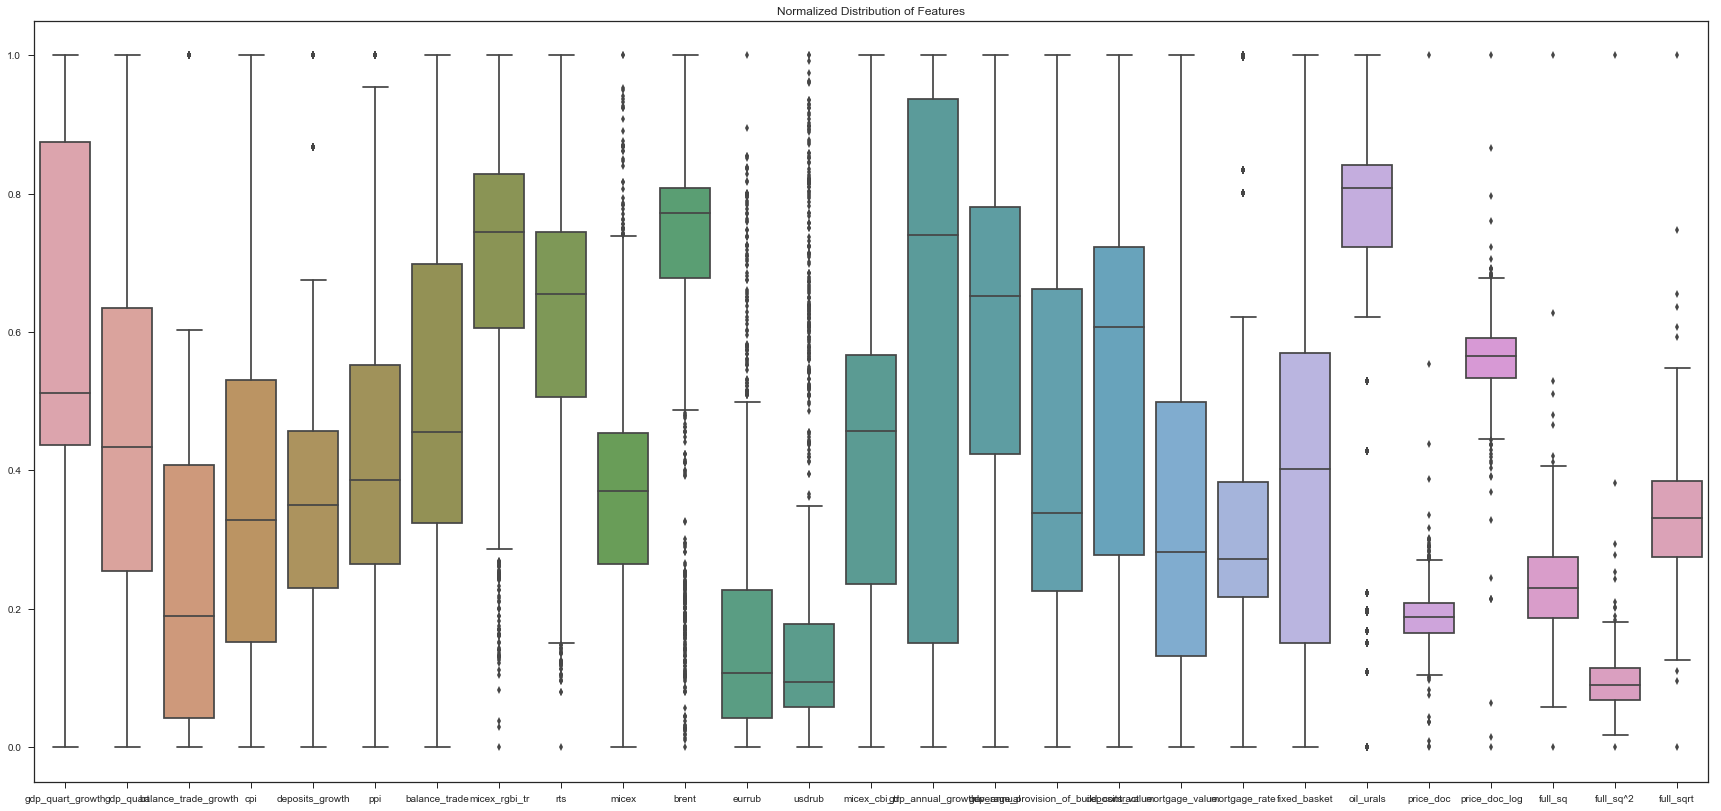

In [338]:
plt.figure(figsize=(30,14))
plt.title('Normalized Distribution of Features')
sns.set_style("ticks")
sns.boxplot(gdp_df,saturation=0.5) # plot scale
plt.show()

### Any relationships between the variables?

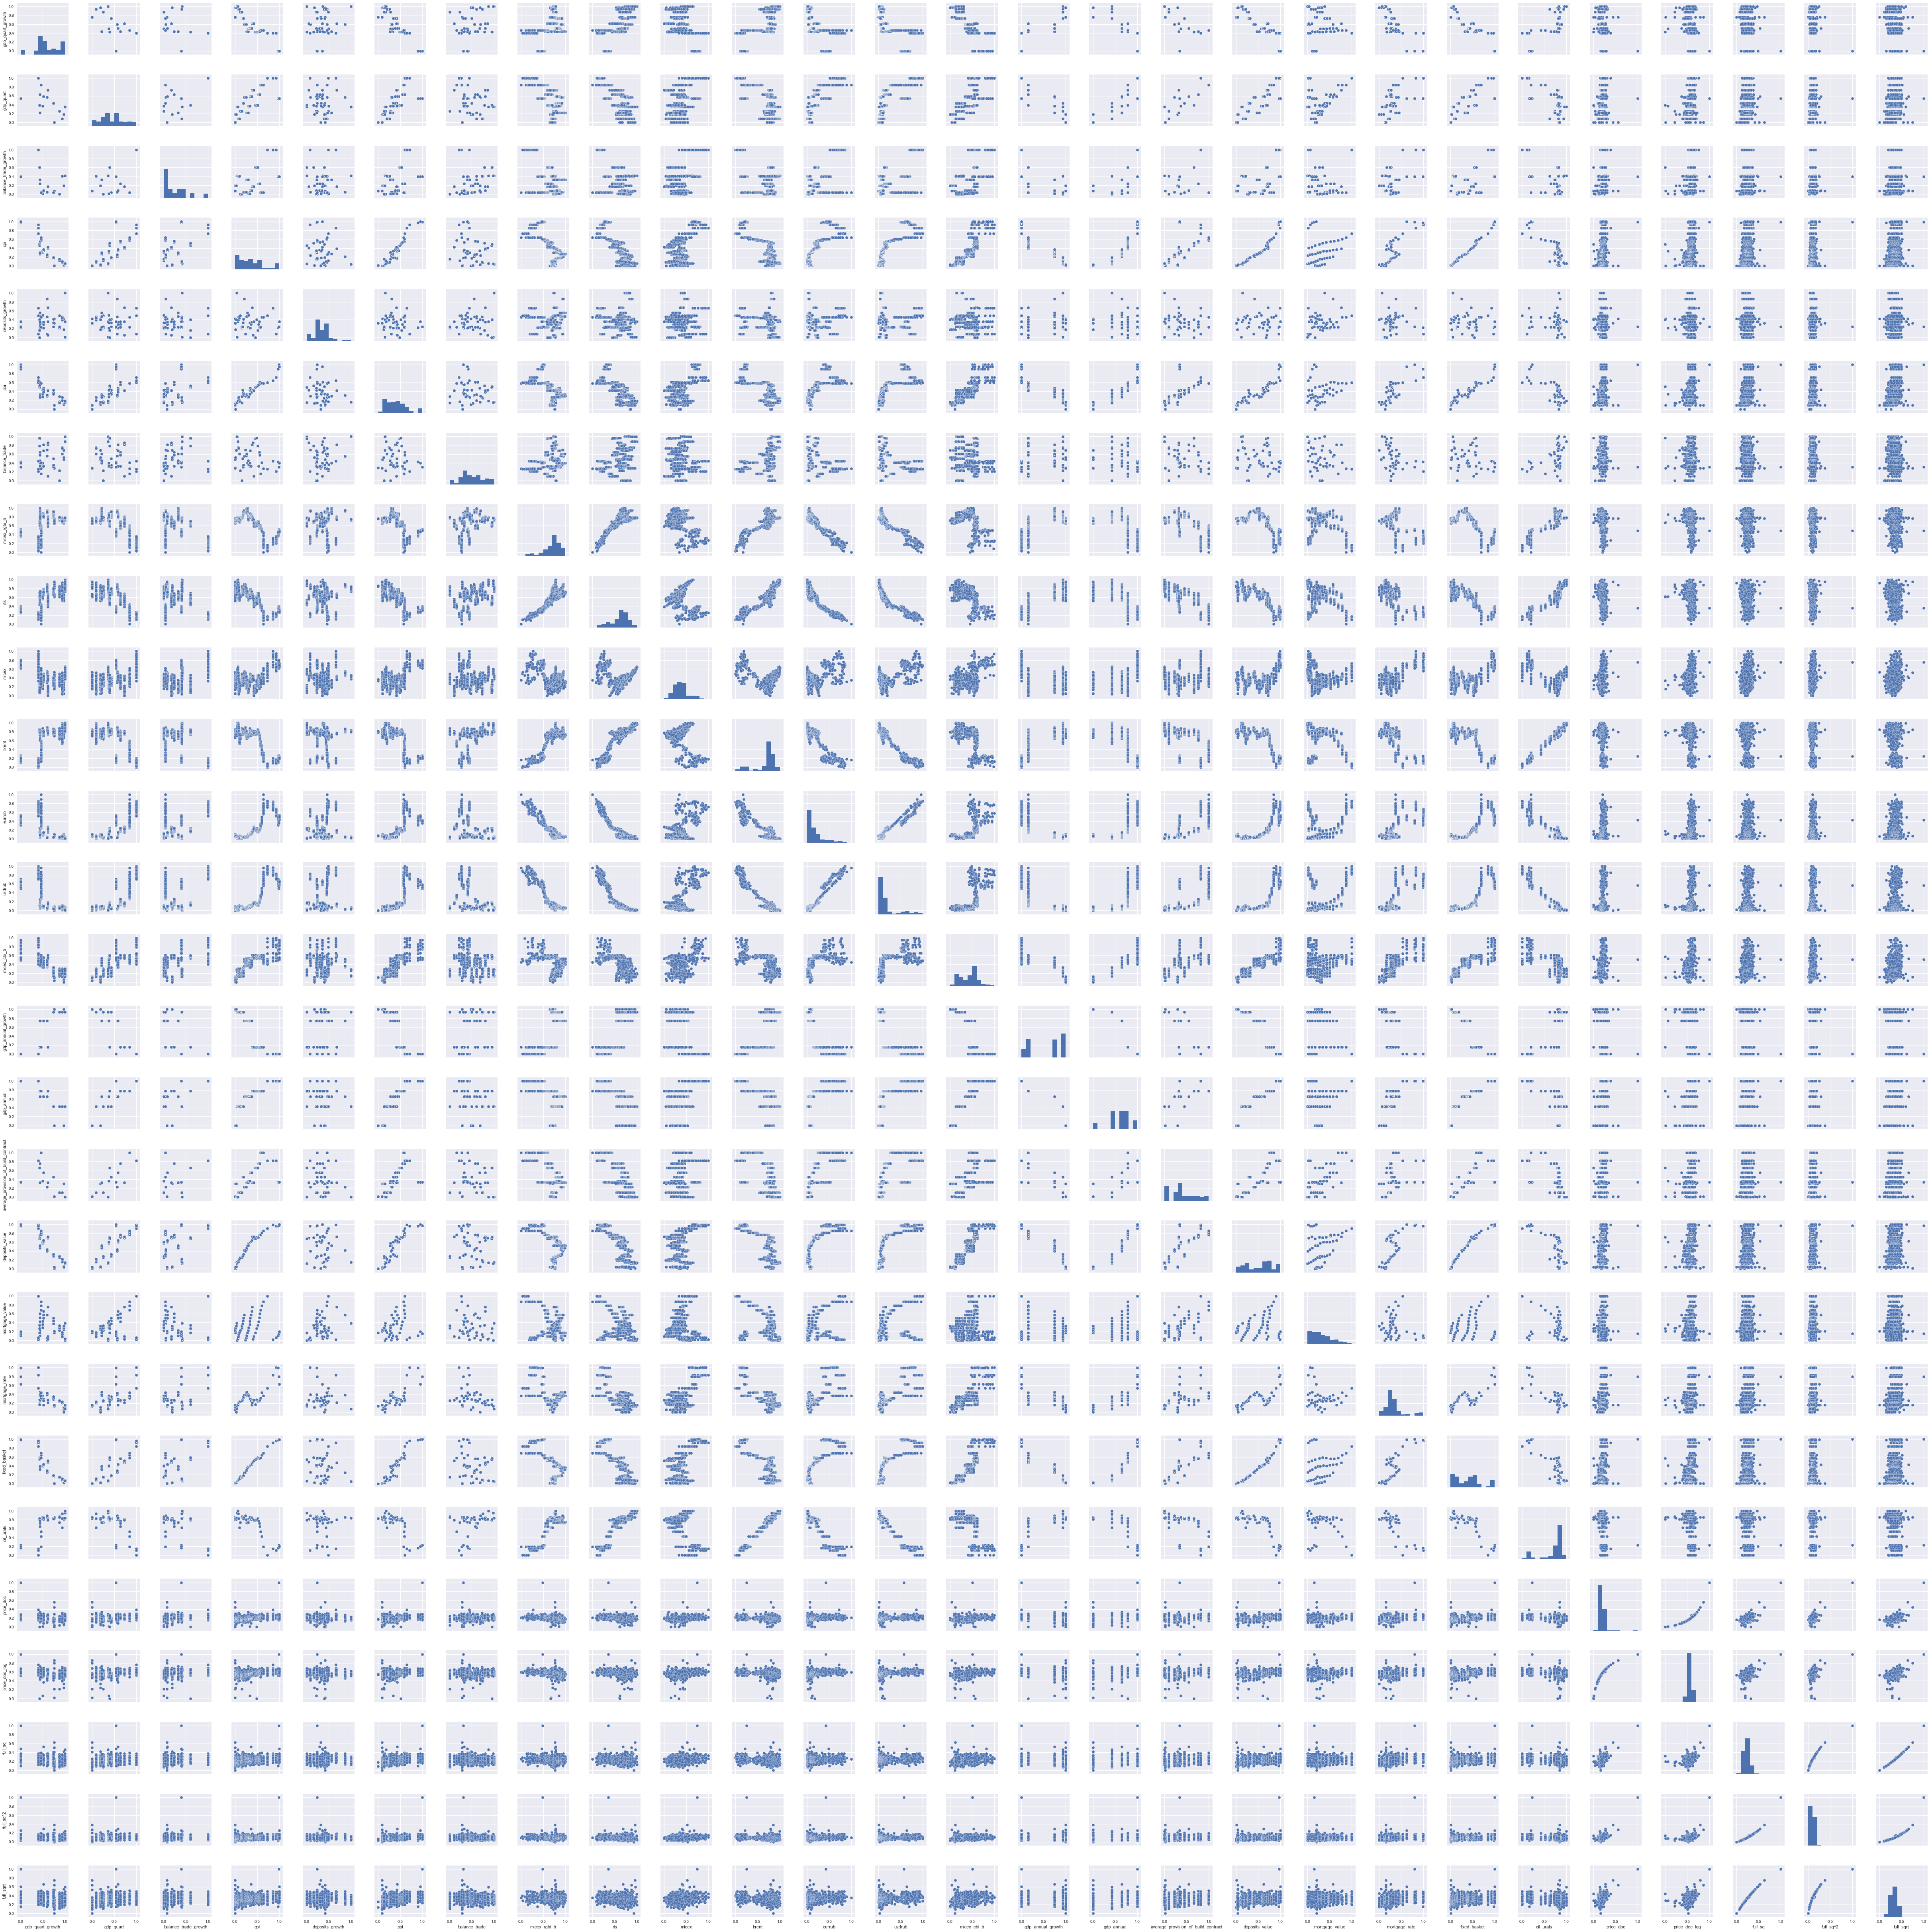

In [203]:
sns.pairplot(gdp_df)

In [126]:
# feature correlation per day with imputed medians
feature_corr = abs(gdp_df.corr()['price_doc']).sort_values(ascending=False) 

In [127]:
feature_corr[(feature_corr < .9) & (feature_corr > .1)]

price_doc_log                          0.899284
full_sq^2                              0.598619
full_sq                                0.495534
full_sqrt                              0.452154
gdp_annual_growth                      0.408022
fixed_basket                           0.402782
cpi                                    0.402716
deposits_value                         0.376970
micex_rgbi_tr                          0.372973
ppi                                    0.371649
eurrub                                 0.368358
usdrub                                 0.364872
gdp_annual                             0.364112
oil_urals                              0.349456
rts                                    0.349273
brent                                  0.336355
micex_cbi_tr                           0.323698
gdp_quart_growth                       0.314387
gdp_quart                              0.282847
balance_trade_growth                   0.280844
mortgage_rate                          0

In [128]:
gdp_df.describe()

gdp_quart_growth    gdp_quart  balance_trade_growth          cpi  \
count       1161.000000  1161.000000           1161.000000  1161.000000   
mean           0.595995     0.468266              0.253819     0.360248   
std            0.259557     0.250484              0.258411     0.275681   
min            0.000000     0.000000              0.000000     0.000000   
25%            0.437500     0.254867              0.042135     0.152381   
50%            0.512500     0.434440              0.189607     0.328938   
75%            0.875000     0.634759              0.407303     0.531136   
max            1.000000     1.000000              1.000000     1.000000   

       deposits_growth          ppi  balance_trade  micex_rgbi_tr  \
count      1161.000000  1161.000000    1161.000000    1161.000000   
mean          0.341299     0.407058       0.505299       0.699423   
std           0.188077     0.216339       0.256280       0.192305   
min           0.000000     0.000000       0.000000       0.000000   
25%           0.229609     0.264175       0.323684       0.606531   
50%           0.349725     0.385954       0.455429       0.744919   
75%           0.457111     0.552835       0.698929       0.829185   
max           1.000000     1.000000       1.000000       1.000000   

               rts        micex     ...       deposits_value  mortgage_value  \
count  1161.000000  1161.000000     ...          1161.000000     1161.000000   
mean      0.610254     0.384580     ...             0.520807        0.324996   
std       0.201098     0.171582     ...             0.291533        0.241246   
min       0.000000     0.000000     ...             0.000000        0.000000   
25%       0.506139     0.264802     ...             0.278256        0.131478   
50%       0.655615     0.370587     ...             0.607788        0.281639   
75%       0.744159     0.454732     ...             0.723236        0.499203   
max       1.000000     1.000000     ...             1.000000        1.000000   

       mortgage_rate  fixed_basket    oil_urals    price_doc  price_doc_log  \
count    1161.000000   1161.000000  1161.000000  1161.000000    1161.000000   
mean        0.331082      0.399378     0.701395     0.188813       0.560645   
std         0.213795      0.286710     0.249661     0.045218       0.060157   
min         0.000000      0.000000     0.000000     0.000000       0.000000   
25%         0.217523      0.150276     0.722973     0.165742       0.533000   
50%         0.271903      0.402491     0.808083     0.188065       0.565503   
75%         0.383686      0.569991     0.841294     0.207957       0.591633   
max         1.000000      1.000000     1.000000     1.000000       1.000000   

           full_sq    full_sq^2    full_sqrt  
count  1161.000000  1161.000000  1161.000000  
mean      0.232925     0.094582     0.331270  
std       0.067731     0.043560     0.080826  
min       0.000000     0.000000     0.000000  
25%       0.186275     0.068624     0.275418  
50%       0.230392     0.090531     0.331085  
75%       0.274510     0.114322     0.384499  
max       1.000000     1.000000     1.000000  

[8 rows x 27 columns]

## Time-Series Analysis

In [121]:
print 'Start Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].min())
print 'End Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].max())

Start Date for Null gdp_quart: 2010-01-01 00:00:00
End Date for Null gdp_quart: 2010-03-31 00:00:00


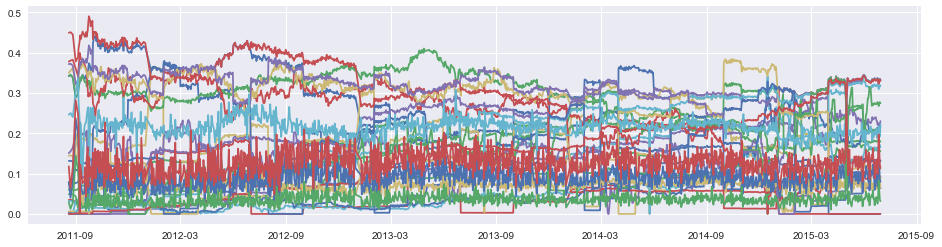

In [200]:
plt.figure(figsize=(16, 4))
plt.plot(norm_gdp)
plt.show()

This needs to be cleaned up with rolling mean windows

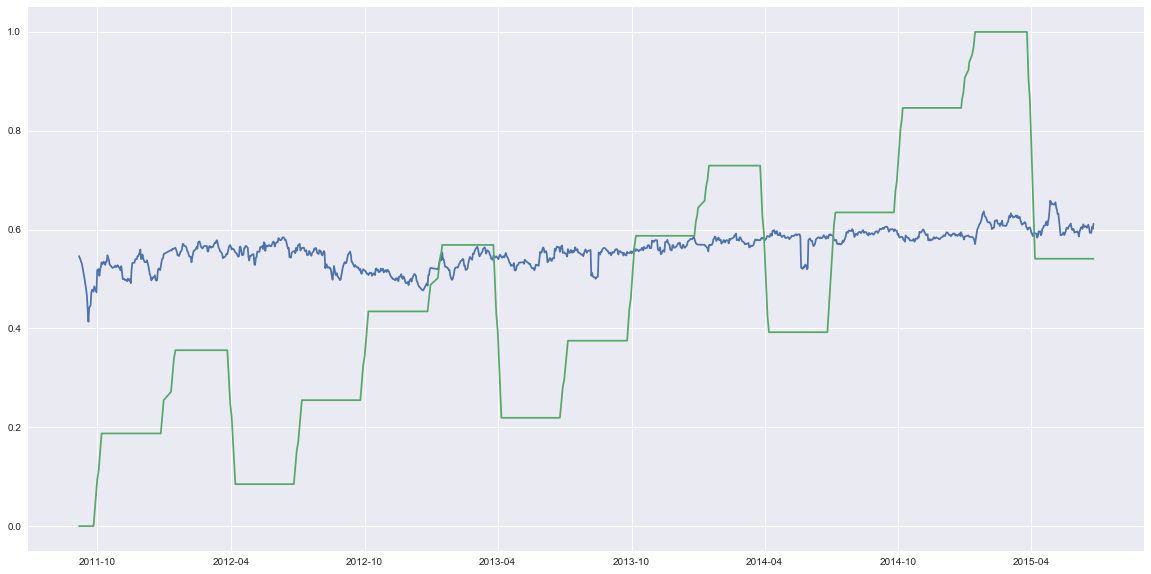

In [237]:
plt.figure(figsize=(20, 10))
plt.plot(gdp_rolling['price_doc_log'])
plt.plot(gdp_rolling['gdp_quart'])
sns.despine()
plt.show()

### Price smoothed out to better find trends

In [211]:
gdp_rolling = gdp_df.rolling(window=10, center=True).mean()

/Users/rezarad/anaconda2/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x178d187d0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


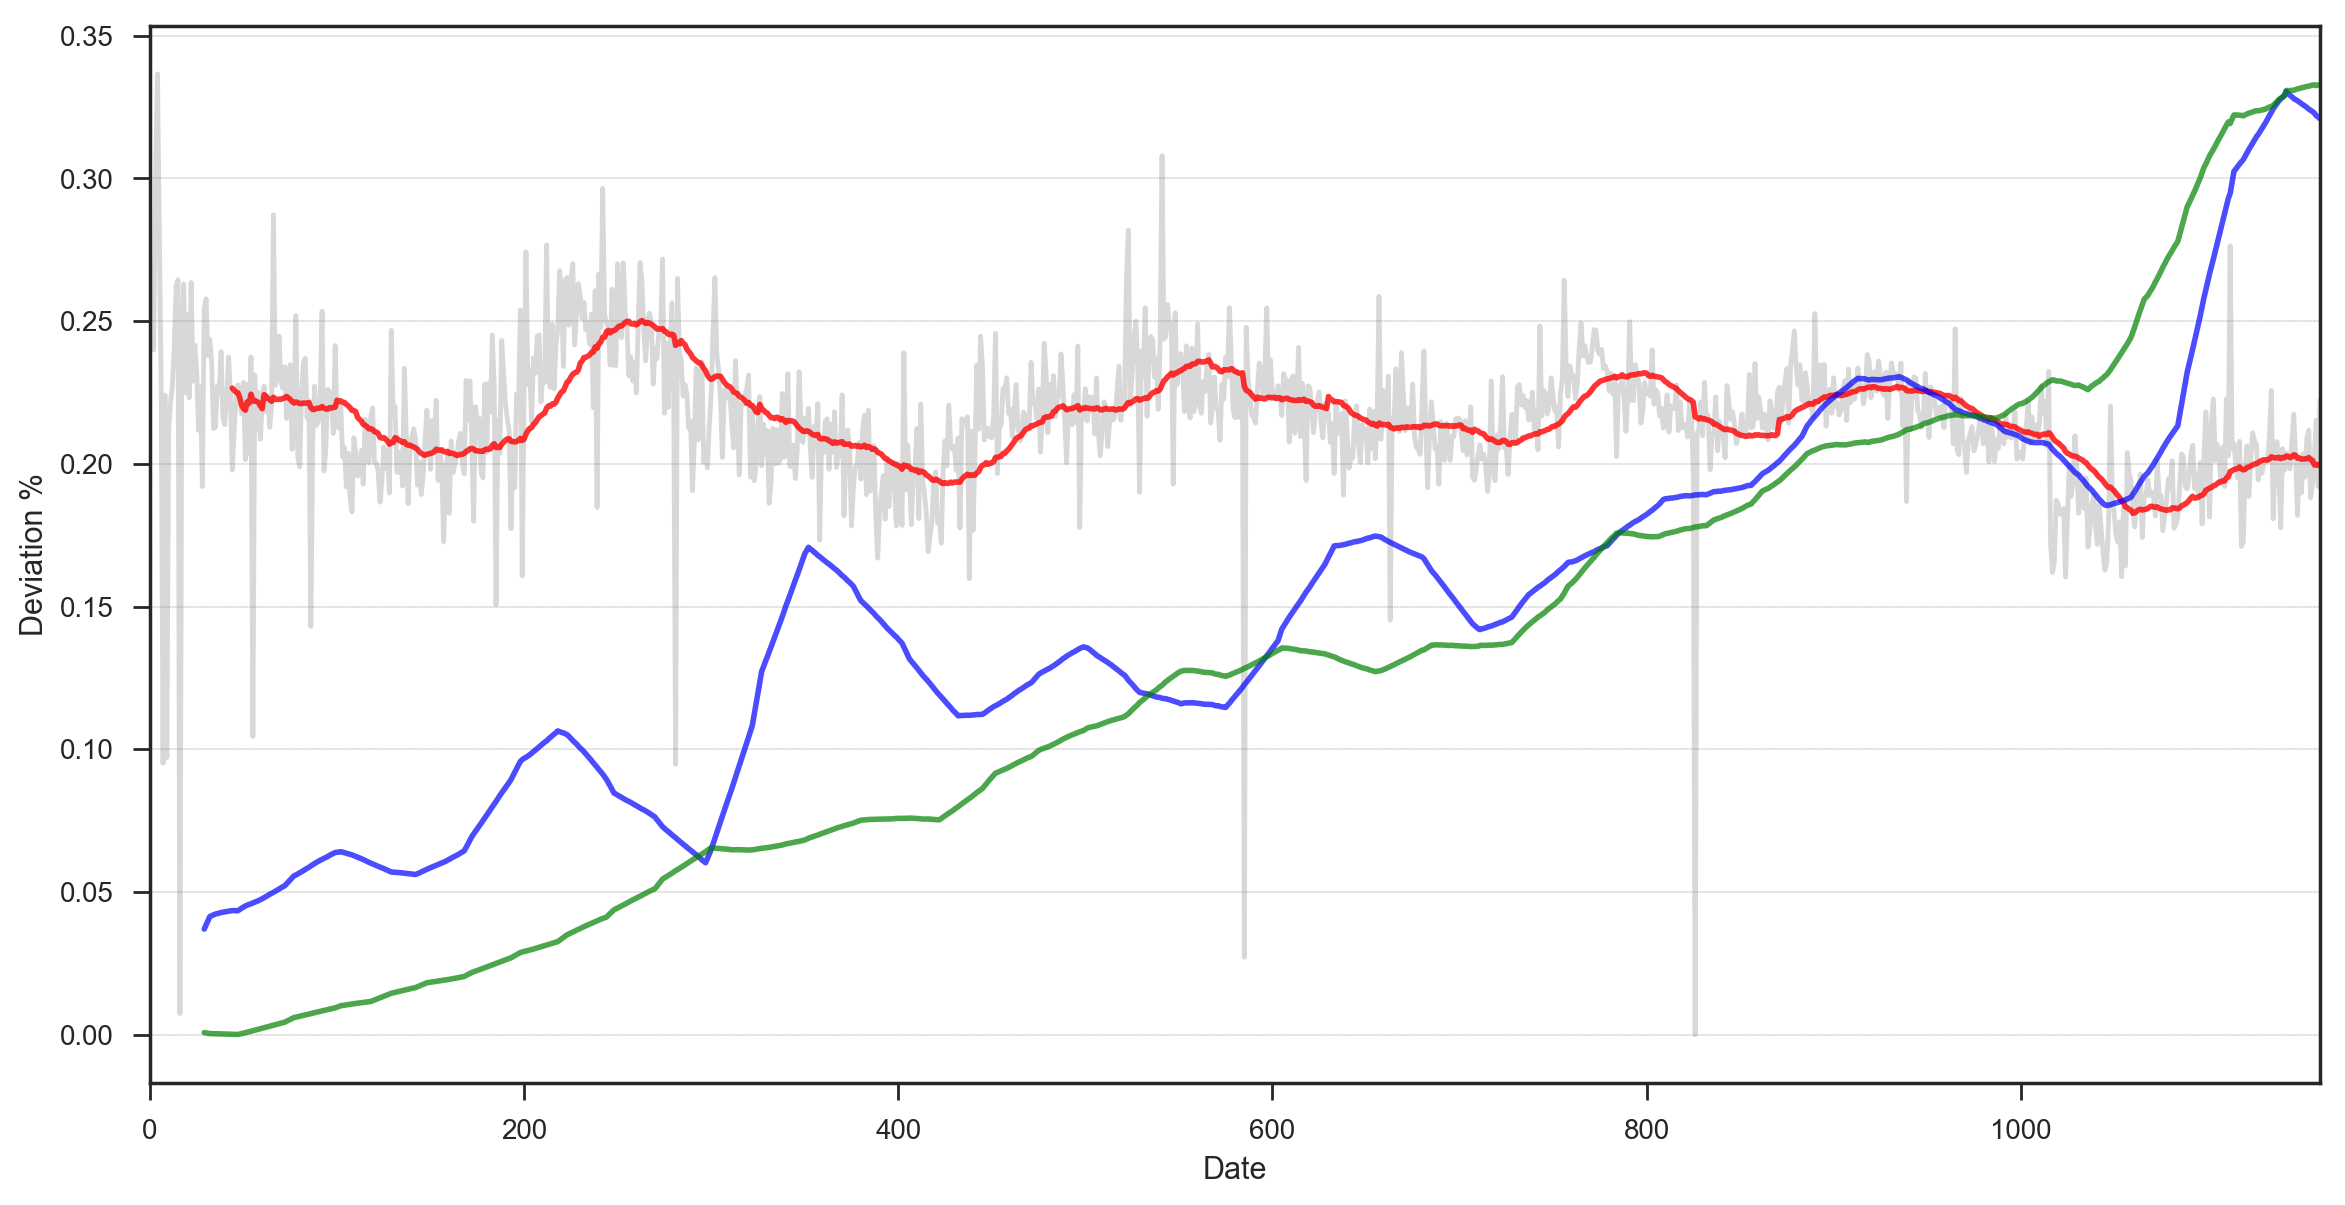

In [425]:
ts_log = norm_gdp['price_doc_log']

moving_avg = ts_log.rolling(window=45).mean()

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)



plt.figure(figsize=(14,7), dpi=200)
sns.set(style="ticks")
plt.xlabel('Date')
plt.xticks()
plt.ylabel('Deviation %')
line1 = sns.tsplot(norm_gdp['price_doc_log'], color='grey', alpha=0.3, legend=True)
line2 = sns.tsplot(moving_avg, color='red', alpha=0.8, lw=2)
line3 = sns.tsplot(norm_gdp['ppi'].rolling(window=30).mean(), lw=2, color='blue', alpha=0.7) 
line4 = sns.tsplot(norm_gdp['cpi'].rolling(window=30).mean(), lw=2, color='green', alpha=0.7)
# snplt.tsplot(norm_gdp['gdp_quart'], color='red')
plt.grid(False, 'major', 'y', ls='--', lw=.1, c='black')
plt.legend(handles=[line1, line2,line3, line4])
plt.show()


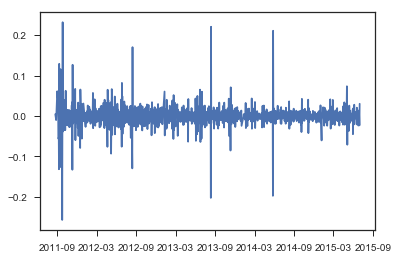

In [408]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

### Log + 1 of CPI vs. PPI vs. Price

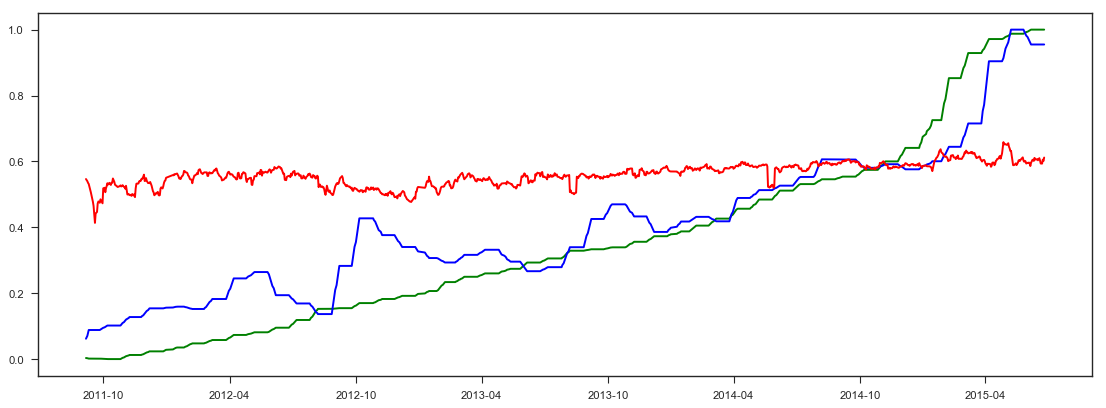

In [420]:
plt.figure(figsize=(17, 6),dpi=80)
plt.plot(gdp_rolling['cpi'], color='green')
plt.plot(gdp_rolling['ppi'], color='blue')
plt.plot(gdp_rolling['price_doc_log'], color='red')
plt.show()

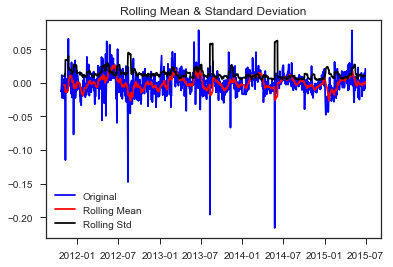

Results of Dickey-Fuller Test:
Test Statistic                -6.328855e+00
p-value                        2.940140e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.112000e+03
Critical Value (5%)           -2.864143e+00
Critical Value (1%)           -3.436244e+00
Critical Value (10%)          -2.568156e+00
dtype: float64


In [414]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(120)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

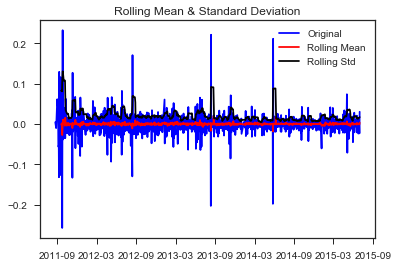

Results of Dickey-Fuller Test:
Test Statistic                -1.375336e+01
p-value                        1.040525e-25
#Lags Used                     1.600000e+01
Number of Observations Used    1.143000e+03
Critical Value (5%)           -2.864072e+00
Critical Value (1%)           -3.436084e+00
Critical Value (10%)          -2.568118e+00
dtype: float64


In [415]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

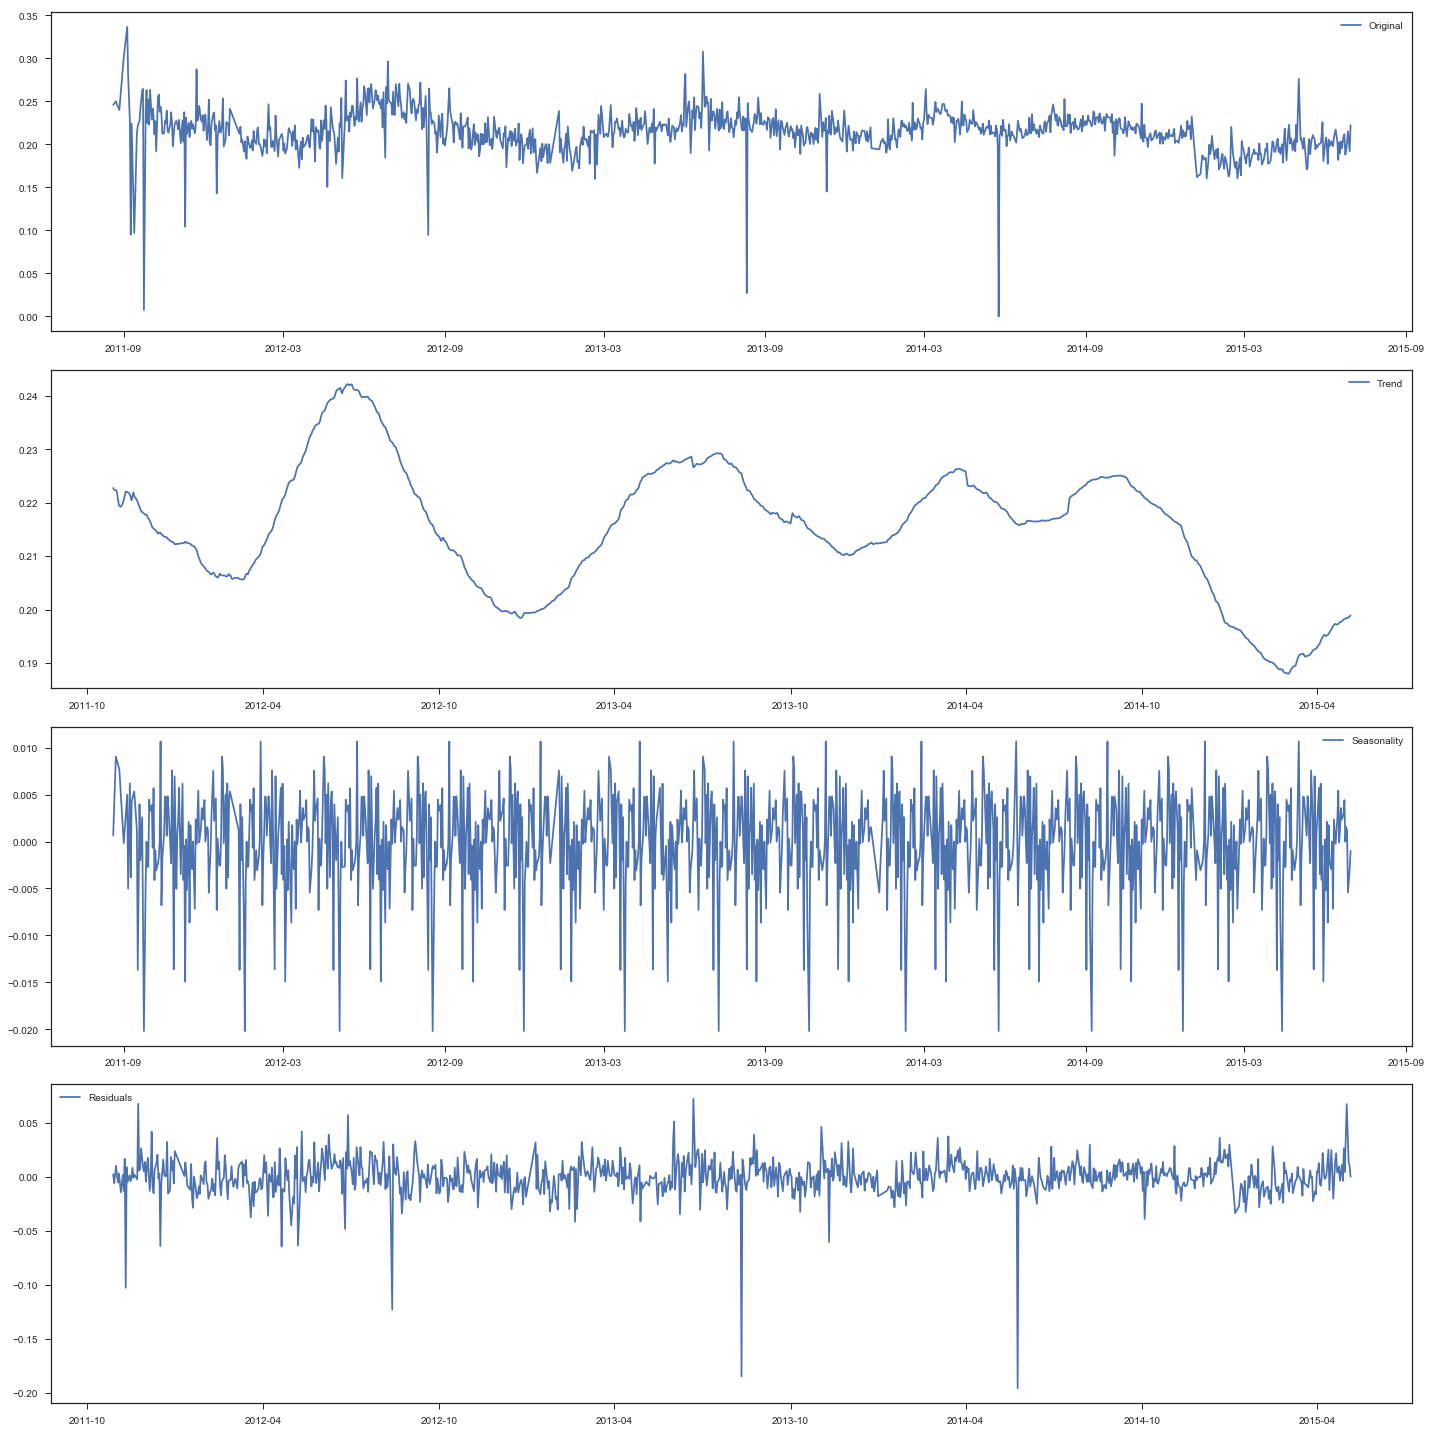

In [416]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=90)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

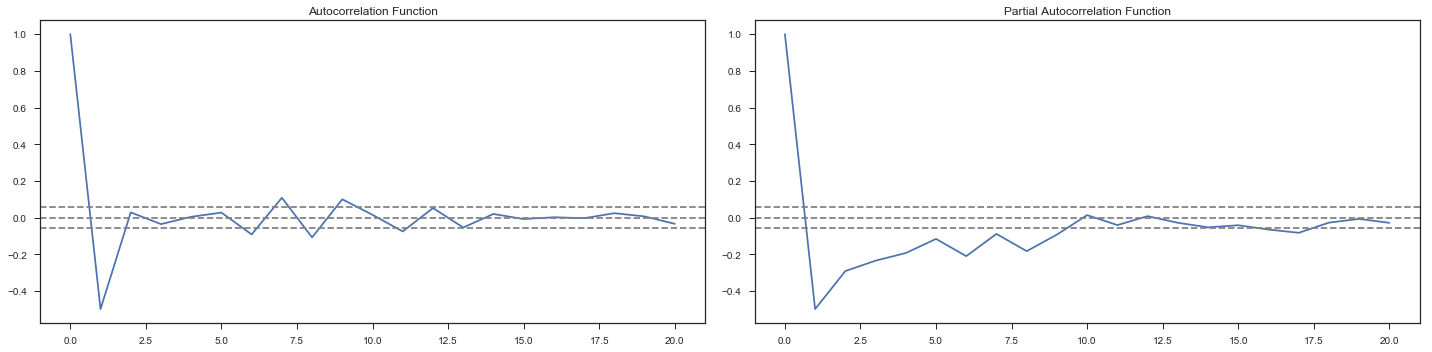

In [417]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/rezarad/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


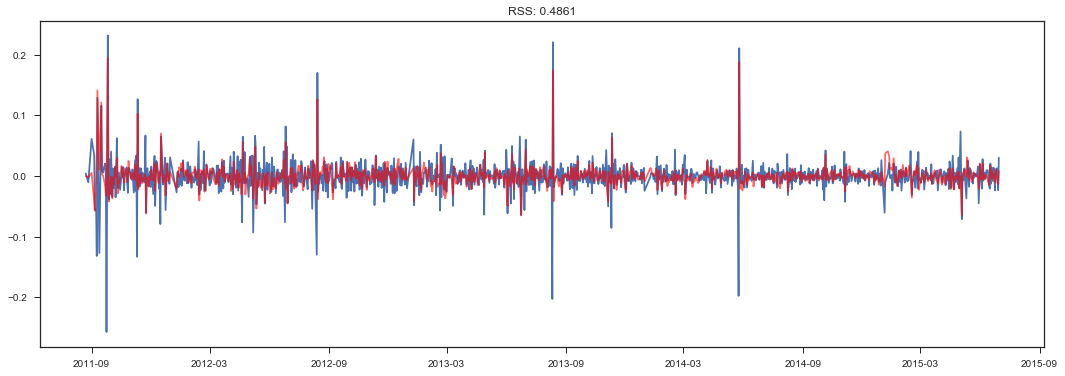

In [418]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(18,6))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red', alpha=0.6)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Euro to Ruble has a slightly strong correlation, so let's remove USD for now.

### Euro to Ruble

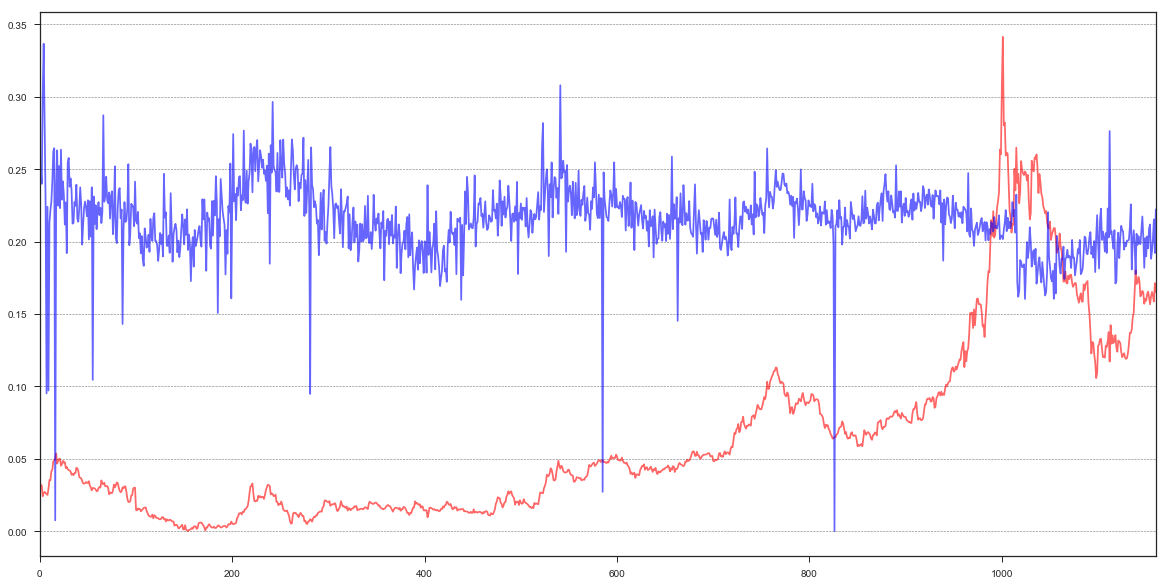

In [419]:
plt.figure(figsize=(20, 10))
sns.set_style("ticks")
sns.tsplot(norm_gdp['eurrub'], color='red', alpha=0.6)
plt.plot()
sns.tsplot(norm_gdp['price_doc_log'], color='blue', alpha=0.6, err_style='ci_band', ci=4)
plt.grid(False, 'major', 'y', ls='--', lw=0.6, c='gray')
plt.show()